# 119-1 e 119-2 BERTimbau

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\msanto22\AppData\Local\Temp\ipykernel_8348\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Sentence Transformers

### RoBERTa Large All

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import numpy as np

C:\Users\msanto22\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\msanto22\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\msanto22\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# Carregar modelo e tokenizer do BERTimbau Large

model_name = 'neuralmind/bert-large-portuguese-cased'  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


In [4]:
# Função para pooling médio
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # Primeiro elemento contém os embeddings dos tokens
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Funções para gerar os vetores de embeddings
def gerar_embedding(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        model_output = model(**inputs)
        # Aplicar pooling médio e normalizar
        sentence_embedding = mean_pooling(model_output, inputs['attention_mask'])
        return sentence_embedding[0].numpy()

def gerar_embeddings_com_hierarquia(json_data, path=''):
    embeddings_hierarquicos = {}
    for chave, valor in json_data.items():
        novo_caminho = f"{path}/{chave}" if path else chave
        if isinstance(valor, dict):
            embeddings_hierarquicos.update(gerar_embeddings_com_hierarquia(valor, novo_caminho))
        elif isinstance(valor, list):
            for texto in valor:
                embedding = gerar_embedding(texto)
                embeddings_hierarquicos[novo_caminho] = embedding
        elif isinstance(valor, str):
            embedding = gerar_embedding(valor)
            embeddings_hierarquicos[novo_caminho] = embedding
    return embeddings_hierarquicos


In [5]:
# Carregar e combinar múltiplos JSONs
def carregar_e_combinar_jsons(*nomes_arquivos, diretorio='idx-07-dimep-JSON'):
    dados_combinados = {}
    for nome_arquivo in nomes_arquivos:
        caminho_completo = f"{diretorio}/{nome_arquivo}.json"
        with open(caminho_completo, 'r', encoding='utf-8') as file:
            dados = json.load(file)
            dados_combinados.update(dados)
    return dados_combinados

# Carregar e combinar os dados dos arquivos JSON
json_data = carregar_e_combinar_jsons('119-1', '119-2')


In [6]:
# Gerar embeddings
embeddings_hierarquicos = gerar_embeddings_com_hierarquia(json_data)

# Salvar os embeddings
np.save('embeddings_sentence_transformers_119-1_119-2_bertimbau.npy', embeddings_hierarquicos)


## Validação dos Embeddings

In [7]:
# Carregar os embeddings
embeddings = np.load('embeddings_sentence_transformers_119-1_119-2_bertimbau.npy', allow_pickle=True)

# Verificar o tipo do objeto carregado
print("Tipo do objeto carregado:", type(embeddings))

# Se for um dicionário ou uma lista, tentar imprimir uma parte dele
if isinstance(embeddings, dict):
    print("Alguns embeddings (chave e vetor):")
    for key in list(embeddings.keys())[:1000]:
        print(key, embeddings[key])
elif isinstance(embeddings, list):
    print("Todos os elementos da lista:", embeddings[:1000])
else:
    print("Conteúdo do objeto:", embeddings)


Tipo do objeto carregado: <class 'numpy.ndarray'>
Conteúdo do objeto: {'Travelers Cheques American Express - TC AMEX/Venda': array([ 0.25190717,  0.03614506,  0.08103559, ...,  0.02420642,
       -0.56373227,  0.08762137], dtype=float32), 'Travelers Cheques American Express - TC AMEX/Compra': array([ 0.41399467,  0.27277526,  0.23195347, ...,  0.3732196 ,
       -0.58749396, -0.20208393], dtype=float32), 'Travelers Cheques American Express - TC AMEX/Reembolso': array([-0.00383699,  0.02453997,  0.32616833, ...,  0.01831348,
       -0.1865685 ,  0.16893819], dtype=float32), 'Travelers Cheques Banco do Brasil - TCBB/Vendas': array([ 0.26506442,  0.06324442,  0.30184582, ...,  0.22519666,
       -0.4046393 , -0.17789589], dtype=float32), 'Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature': array([ 0.03513015,  0.23447156,  0.41373748, ..., -0.14064027,
       -0.3912194 , -0.09375283], dtype=float32), 'Travelers Cheques Banco do Brasil - TCBB/Características do TCBB': array([ 0

In [8]:
# Verificar alguns embeddings
for key in list(embeddings.item().keys())[:1000]:
    embedding = embeddings.item()[key]
    print(f"Embedding para '{key}': Shape - {embedding.shape}, Tipo - {embedding.dtype}")
    print(embedding, "\n")


Embedding para 'Travelers Cheques American Express - TC AMEX/Venda': Shape - (1024,), Tipo - float32
[ 0.25190717  0.03614506  0.08103559 ...  0.02420642 -0.56373227
  0.08762137] 

Embedding para 'Travelers Cheques American Express - TC AMEX/Compra': Shape - (1024,), Tipo - float32
[ 0.41399467  0.27277526  0.23195347 ...  0.3732196  -0.58749396
 -0.20208393] 

Embedding para 'Travelers Cheques American Express - TC AMEX/Reembolso': Shape - (1024,), Tipo - float32
[-0.00383699  0.02453997  0.32616833 ...  0.01831348 -0.1865685
  0.16893819] 

Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Vendas': Shape - (1024,), Tipo - float32
[ 0.26506442  0.06324442  0.30184582 ...  0.22519666 -0.4046393
 -0.17789589] 

Embedding para 'Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature': Shape - (1024,), Tipo - float32
[ 0.03513015  0.23447156  0.41373748 ... -0.14064027 -0.3912194
 -0.09375283] 

Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Características do TCBB'

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Verificar a forma de alguns embeddings
for key in list(embeddings.item().keys())[:1000]:
    embedding = embeddings.item()[key]
    print(f"Embedding para '{key}': Shape - {embedding.shape}")


Embedding para 'Travelers Cheques American Express - TC AMEX/Venda': Shape - (1024,)
Embedding para 'Travelers Cheques American Express - TC AMEX/Compra': Shape - (1024,)
Embedding para 'Travelers Cheques American Express - TC AMEX/Reembolso': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Vendas': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Características do TCBB': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Reembolso': Shape - (1024,)
Embedding para 'Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular': Shape - (1024,)
Embedding para 'Amex - Conferência de Estoque/Agências e PSO/SOP': Shape - (1024,)
Embedding para 'Amex - Extravio/Agências': Shape - (1024,)
Embedding para 'Amex - Destruição/Agências': Shape - (1024,)
Embedding para 'Amex - Free Exchange/Agên

In [10]:
# Achatar os embeddings para 1D se eles forem 2D
flattened_embeddings = [embeddings.item()[key].flatten() for key in embeddings.item().keys()]

# Convertendo de volta para array NumPy
flattened_embeddings = np.array(flattened_embeddings)

# Obter o número total de embeddings
n_samples = len(flattened_embeddings)

# Ajustar a perplexidade para um valor adequado
perplexity = max(5, min(n_samples - 1, 1000))  # Definindo um limite mínimo de 5

In [11]:
# Verificação Simples dos Embeddings

for embedding in flattened_embeddings[:1000]:
    print("Média:", np.mean(embedding))
    print("Desvio padrão:", np.std(embedding), "\n")


Média: -0.0285041
Desvio padrão: 0.45885646 

Média: -0.027723527
Desvio padrão: 0.46667266 

Média: -0.028204184
Desvio padrão: 0.4507573 

Média: -0.028317453
Desvio padrão: 0.4360597 

Média: -0.027935926
Desvio padrão: 0.47773477 

Média: -0.028092451
Desvio padrão: 0.49447402 

Média: -0.028043933
Desvio padrão: 0.4401298 

Média: -0.027504124
Desvio padrão: 0.47102404 

Média: -0.028149052
Desvio padrão: 0.44911364 

Média: -0.028279256
Desvio padrão: 0.4657674 

Média: -0.028267547
Desvio padrão: 0.45623338 

Média: -0.028451607
Desvio padrão: 0.4558569 

Média: -0.028448112
Desvio padrão: 0.4871653 

Média: -0.02779175
Desvio padrão: 0.47332984 

Média: -0.027920095
Desvio padrão: 0.47777492 

Média: -0.028275698
Desvio padrão: 0.4489826 

Média: -0.027104413
Desvio padrão: 0.49701902 



<hr>

# 1º Gráfico: Sentence Transformers (RoBERTa)
# 2º Gráfico: BERTimbau Large

Text(0, 0.5, 'Componente 2')

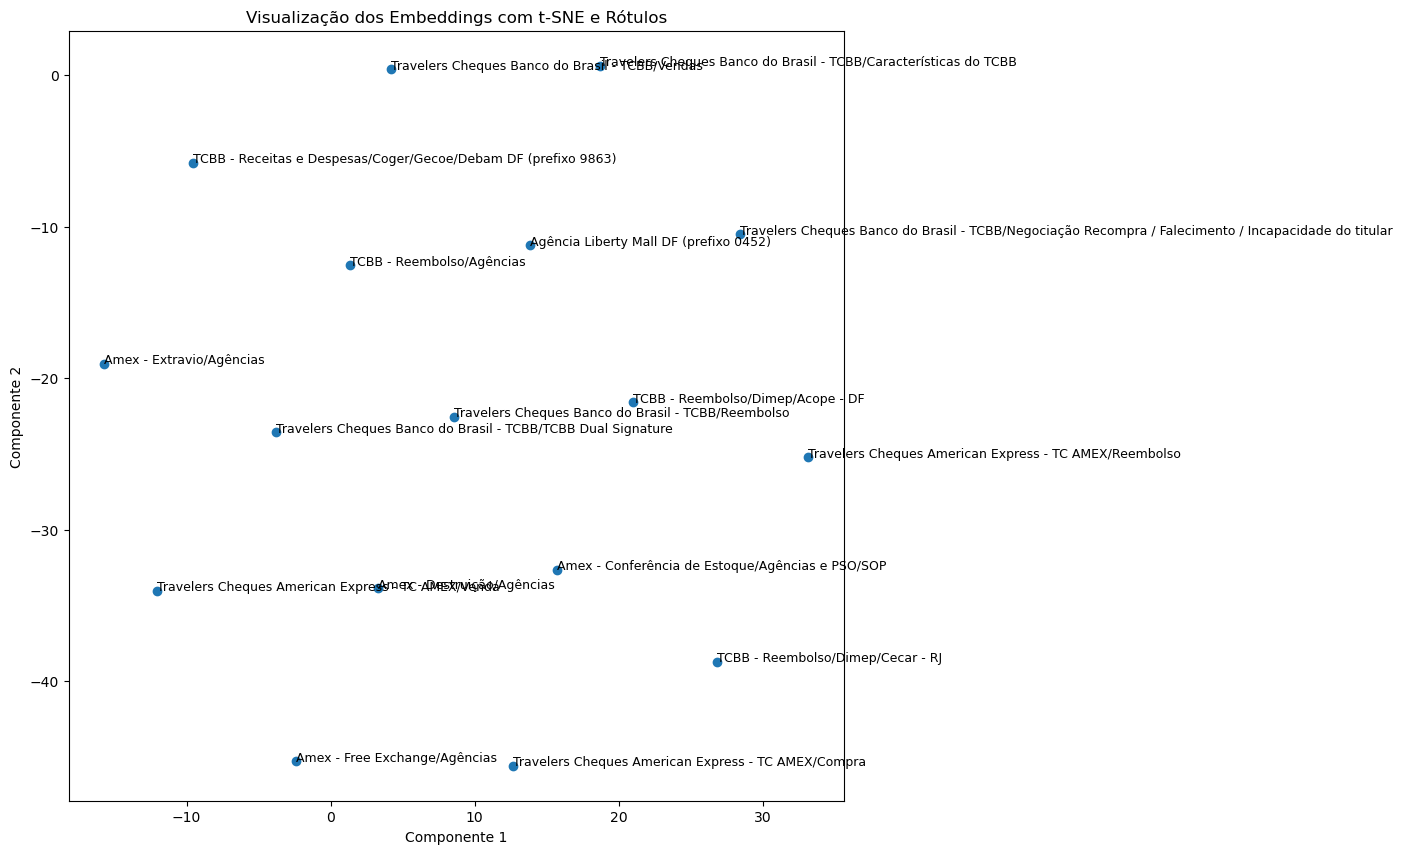

In [37]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_2d = TSNE(n_components=2, perplexity=perplexity).fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com t-SNE e Rótulos")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")


Text(0, 0.5, 'Componente 2')

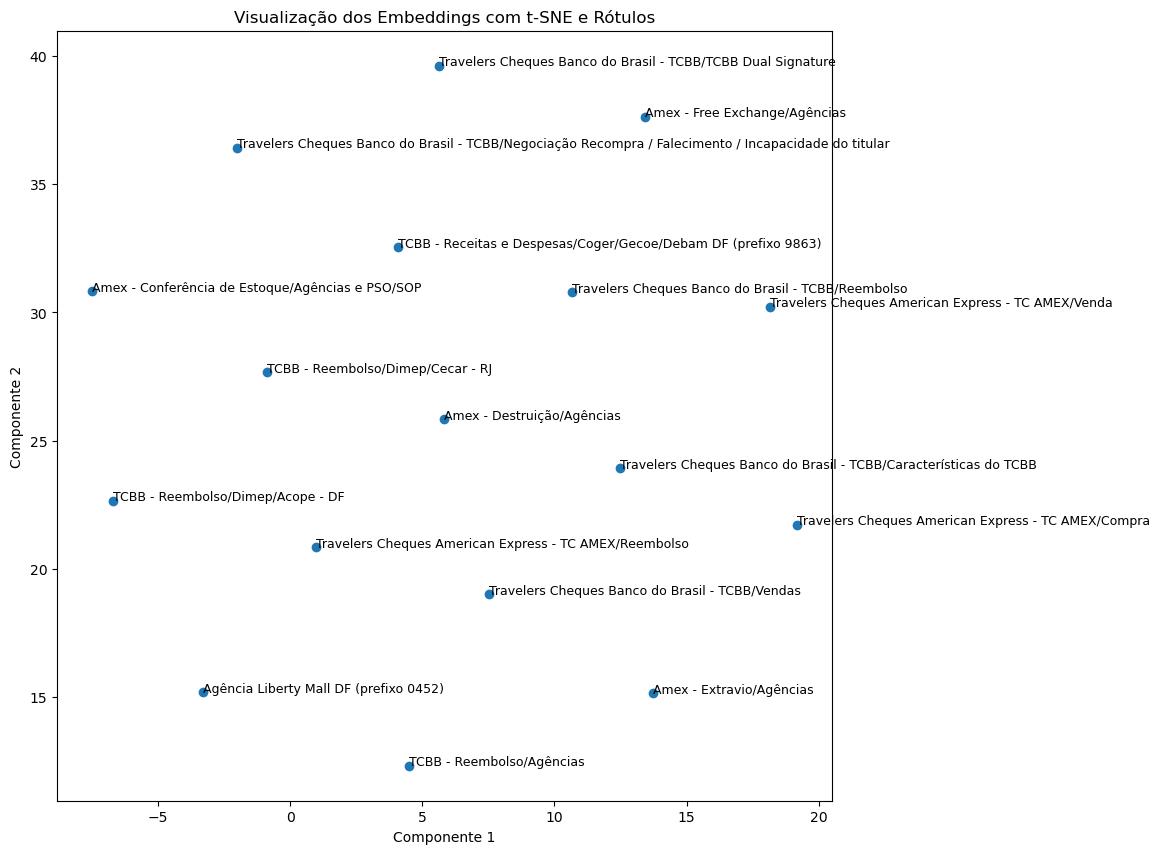

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_2d = TSNE(n_components=2, perplexity=perplexity).fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com t-SNE e Rótulos")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")


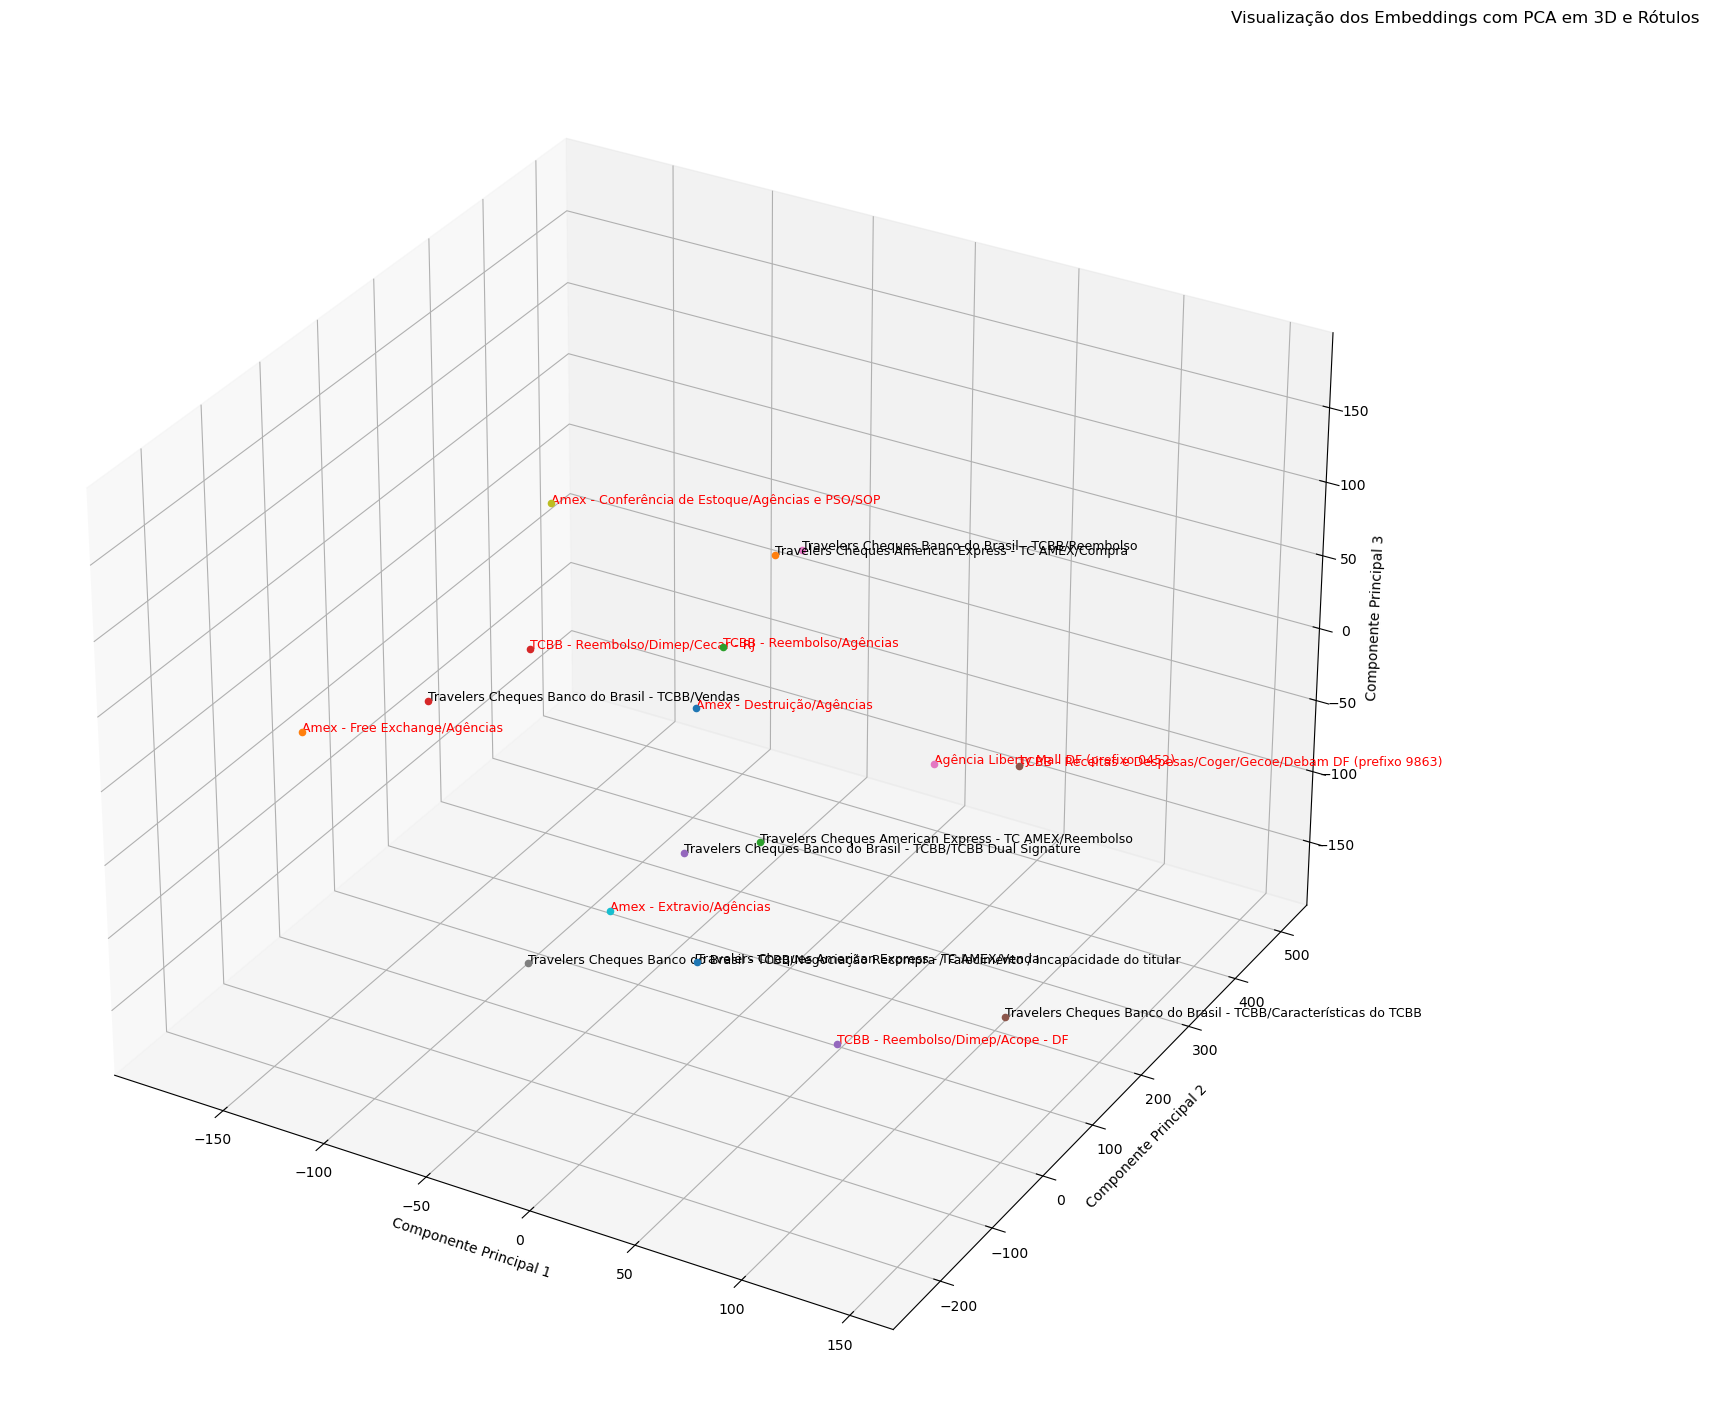

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_3d = TSNE(n_components=3, perplexity=perplexity).fit_transform(flattened_embeddings)

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]


# Iterar sobre os embeddings
for i in range(embeddings_3d.shape[0]):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i <= 7:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], fontsize=9)        
    else:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], color='red', fontsize=9)

        
ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([1.05, 0.2])


# Ajustar a posição do título para evitar o corte
ax.title.set_position([1.05, 0.2])  # Ajuste conforme necessário

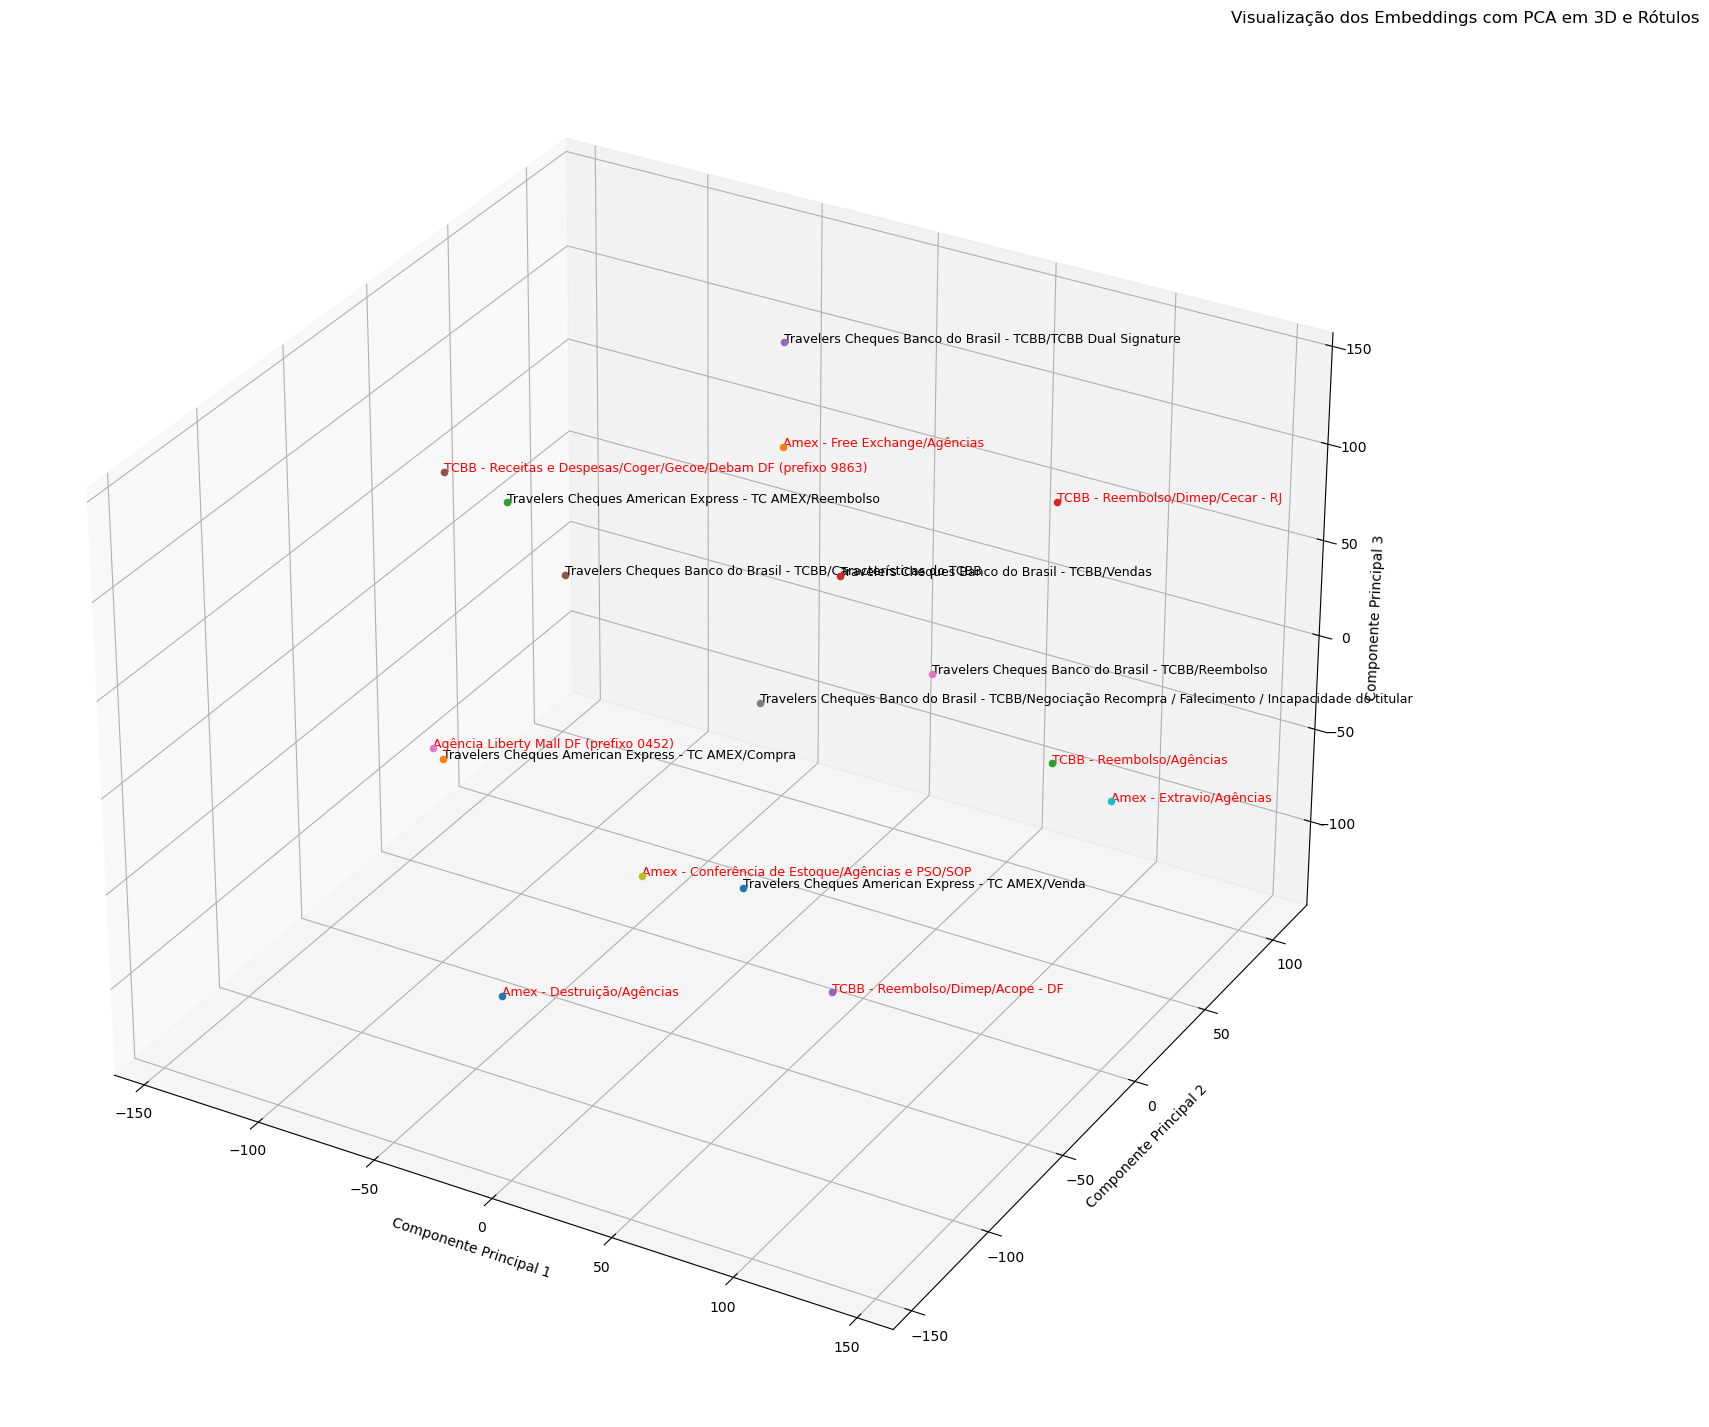

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Aplicar t-SNE
embeddings_3d = TSNE(n_components=3, perplexity=perplexity).fit_transform(flattened_embeddings)

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]


# Iterar sobre os embeddings
for i in range(embeddings_3d.shape[0]):
    ax.scatter(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i <= 7:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], fontsize=9)        
    else:
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], labels[i], color='red', fontsize=9)

        
ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([1.05, 0.2])


# Ajustar a posição do título para evitar o corte
ax.title.set_position([1.05, 0.2])  # Ajuste conforme necessário

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Supondo que `embeddings_3d` seja a sua matriz de embeddings após aplicar t-SNE e contenha 8 vetores
# Calcular a similaridade de cosseno entre esses 9 embeddings
similarity_matrix = cosine_similarity(embeddings_3d)

# Imprimir a matriz de similaridade
print("Matriz de Similaridade de Cosseno:")
print(similarity_matrix)


Matriz de Similaridade de Cosseno:
[[ 1.          0.51918656 -0.31224847  0.37962303 -0.44392547  0.45968112
  -0.7038104  -0.32674927 -0.36247915 -0.00485435  0.5540218  -0.98163176
   0.57680714 -0.4174159   0.42220303 -0.7898781  -0.26189932]
 [ 0.51918656  1.0000001   0.56482935  0.14325303 -0.09523136  0.73714966
  -0.84428203 -0.67613333 -0.19790615 -0.8343733   0.63250697 -0.5379486
  -0.33254716 -0.8215668  -0.16714005  0.10306188  0.50208265]
 [-0.31224847  0.56482935  0.99999994  0.21842685  0.64640886  0.6359377
  -0.44159552 -0.7135575  -0.29080746 -0.923429   -0.13789228  0.3578525
  -0.66225004 -0.2304237  -0.84879833  0.7045066   0.4579899 ]
 [ 0.37962303  0.14325303  0.21842685  0.99999994  0.6355677   0.75589234
  -0.6349549  -0.76624405 -0.9970483  -0.15228719 -0.4872013  -0.1971422
   0.58587676  0.4122415  -0.5364865  -0.4529178  -0.7109578 ]
 [-0.44392547 -0.09523136  0.64640886  0.6355677   1.          0.47889948
  -0.16138817 -0.5980694  -0.66282105 -0.3542219  -

Text(0.5, 1.0, 'Heatmap da Similaridade de Cosseno t-SNE')

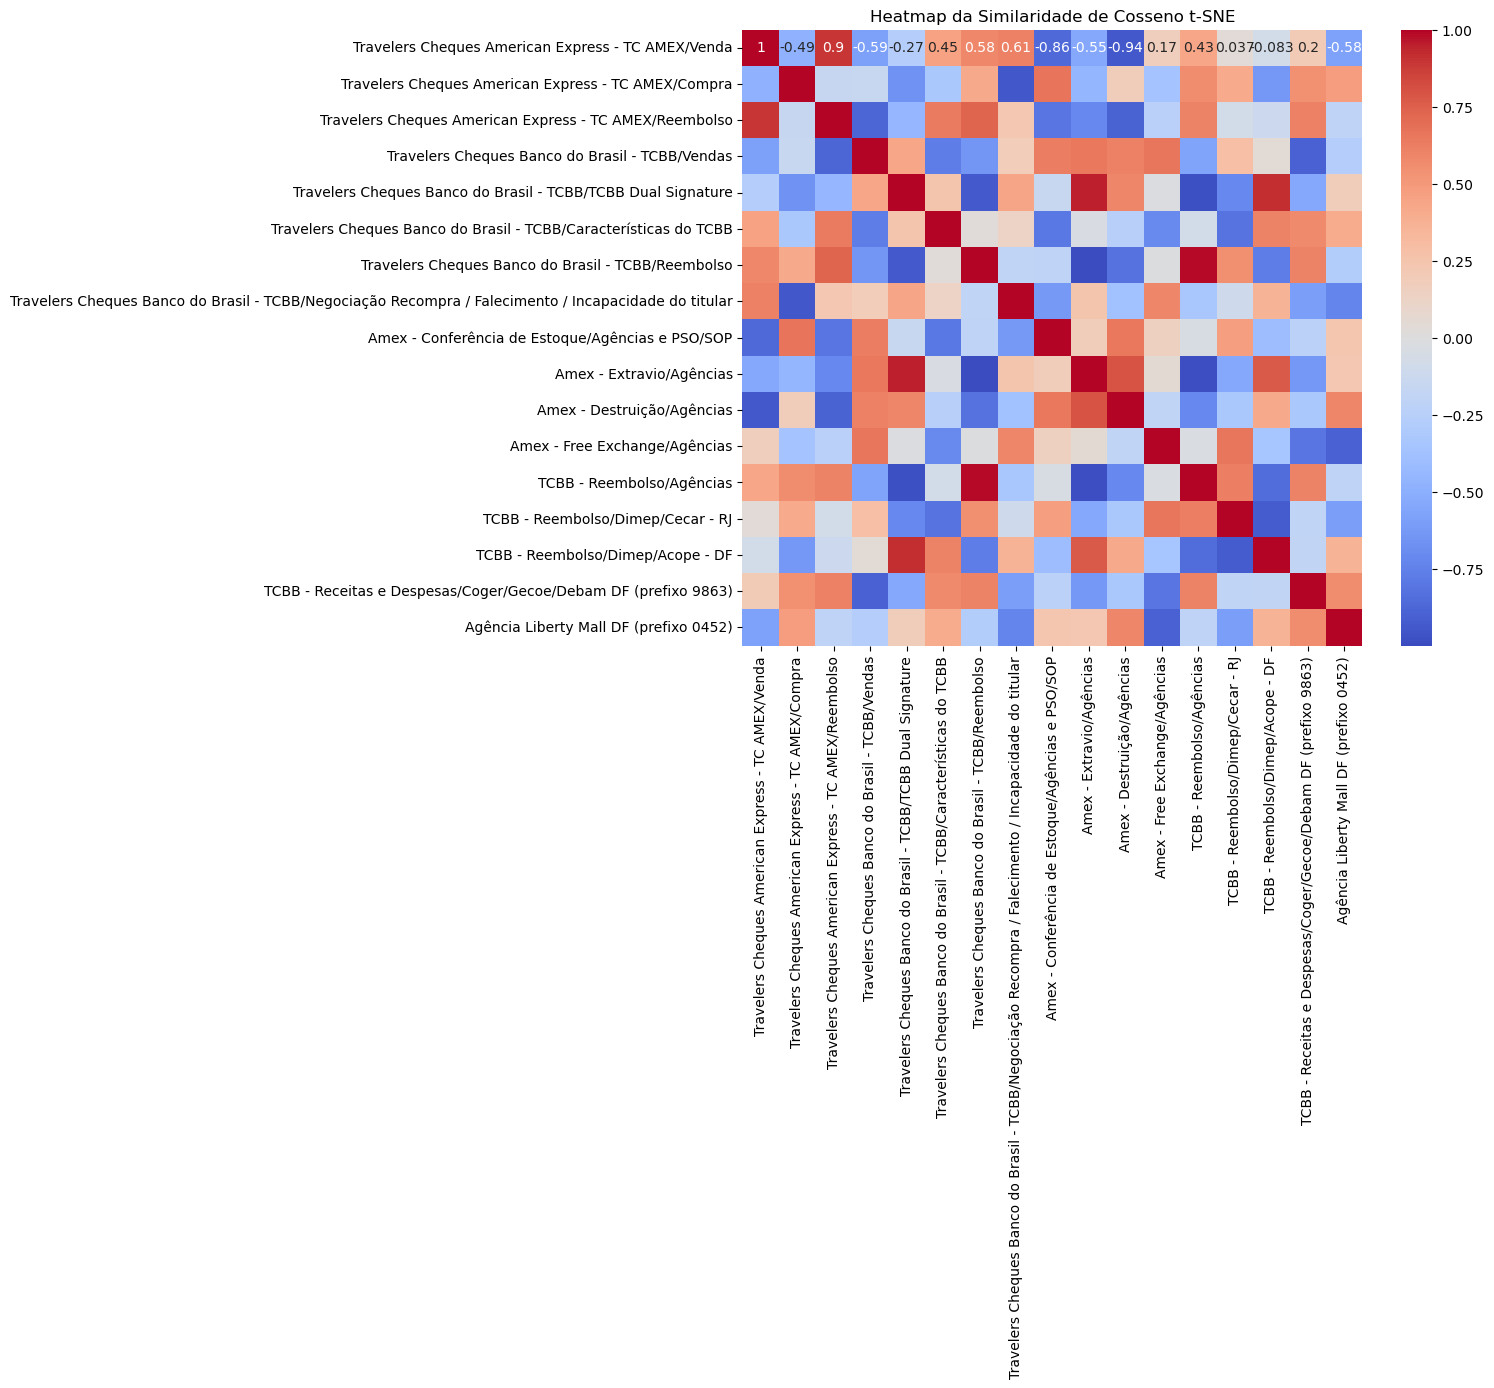

In [40]:
import seaborn as sns

# Heatmap da matriz de similaridade de cosseno para os 9 embeddings
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno t-SNE")


Text(0.5, 1.0, 'Heatmap da Similaridade de Cosseno t-SNE')

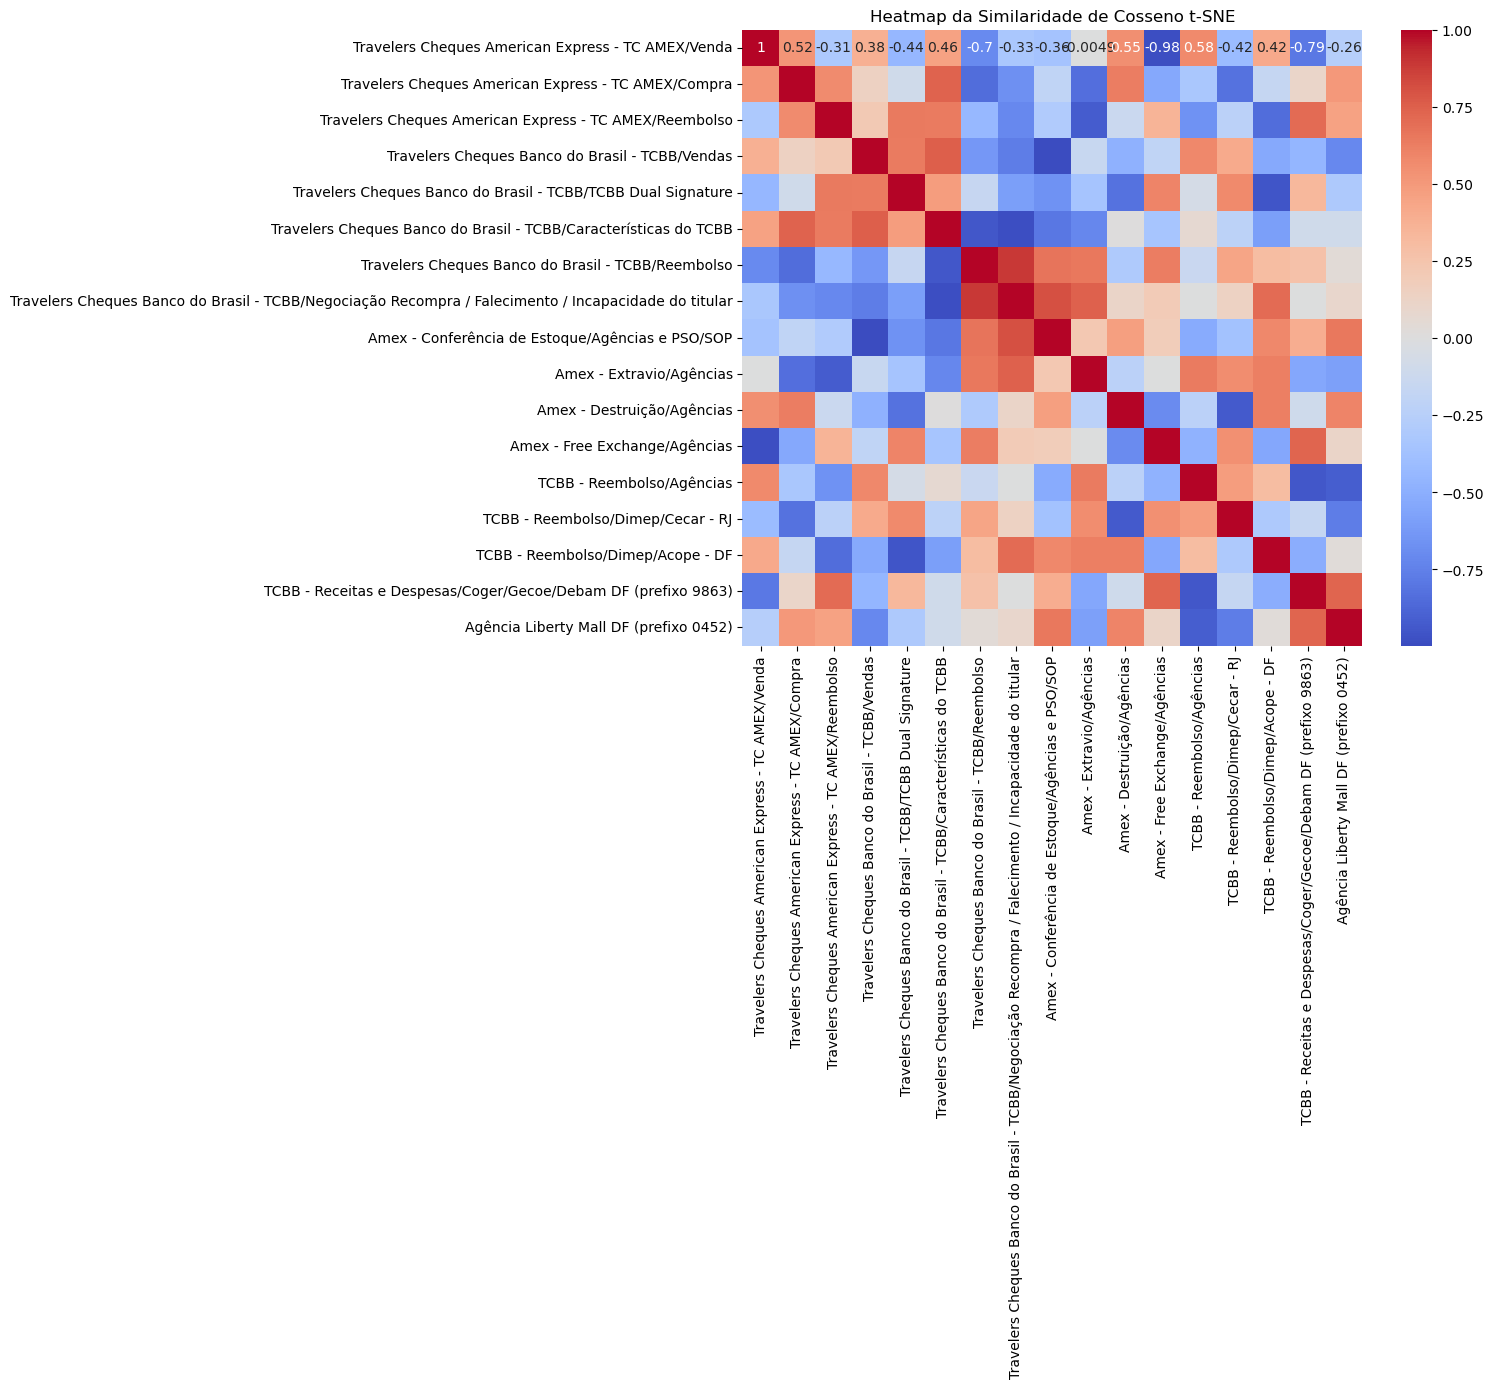

In [15]:
import seaborn as sns

# Heatmap da matriz de similaridade de cosseno para os 9 embeddings
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno t-SNE")


Text(0, 0.5, 'Componente Principal 2')

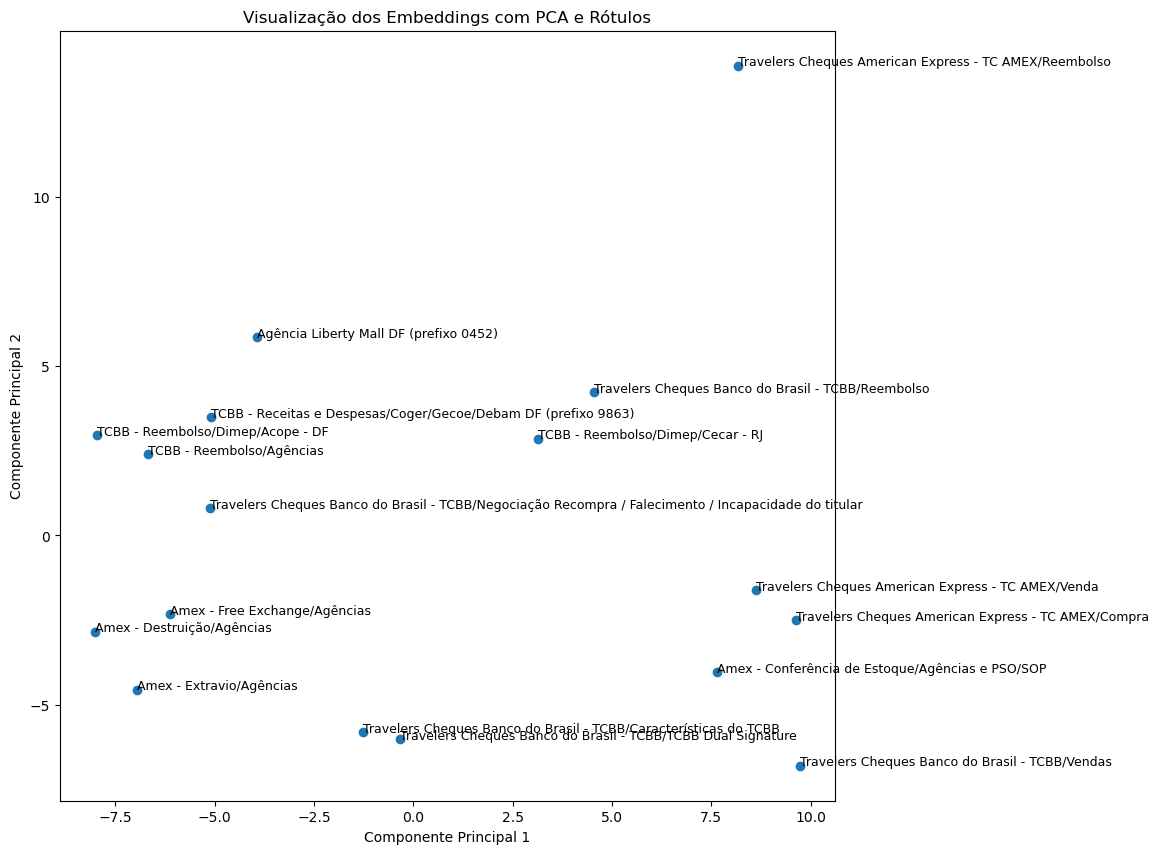

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com PCA e Rótulos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")


Text(0, 0.5, 'Componente Principal 2')

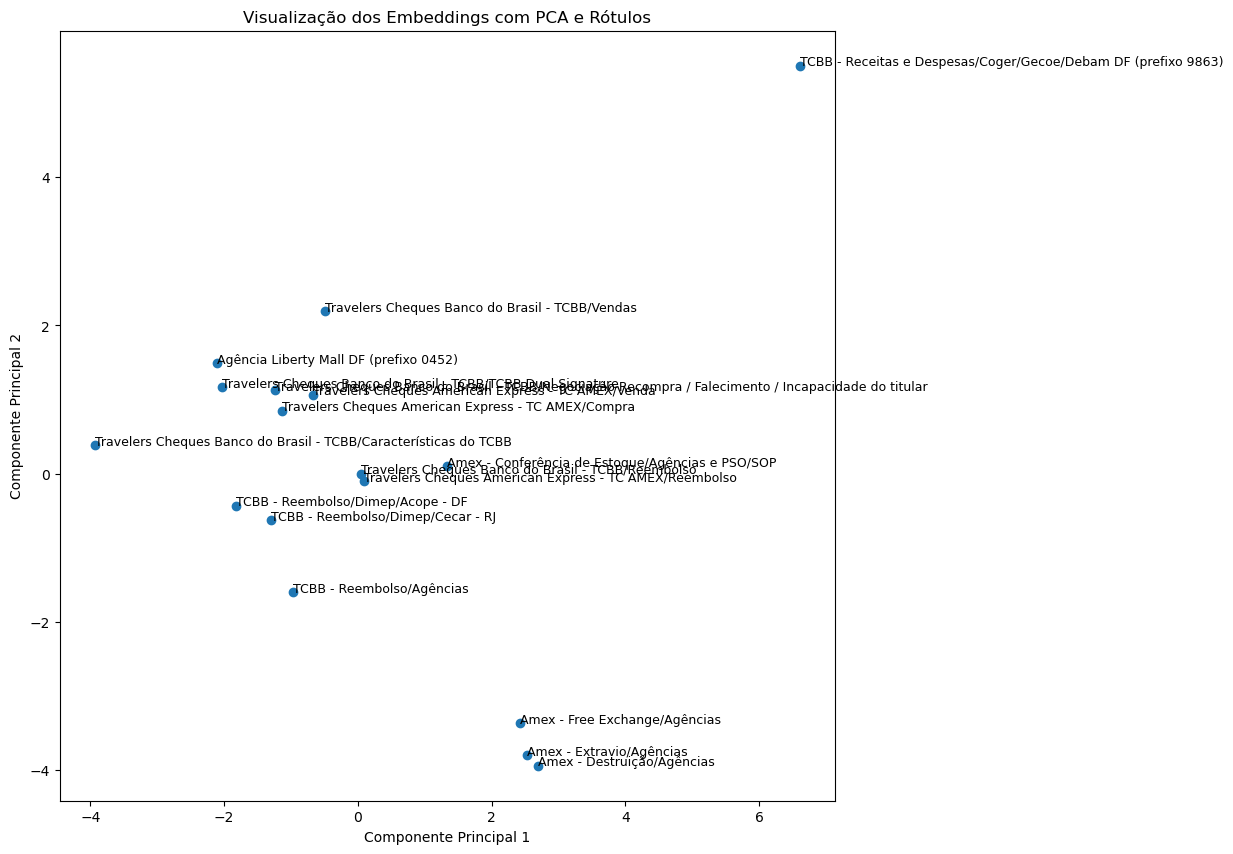

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(flattened_embeddings)

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Plotar a visualização 2D dos embeddings com rótulos
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Adicionar rótulos aos pontos
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualização dos Embeddings com PCA e Rótulos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")


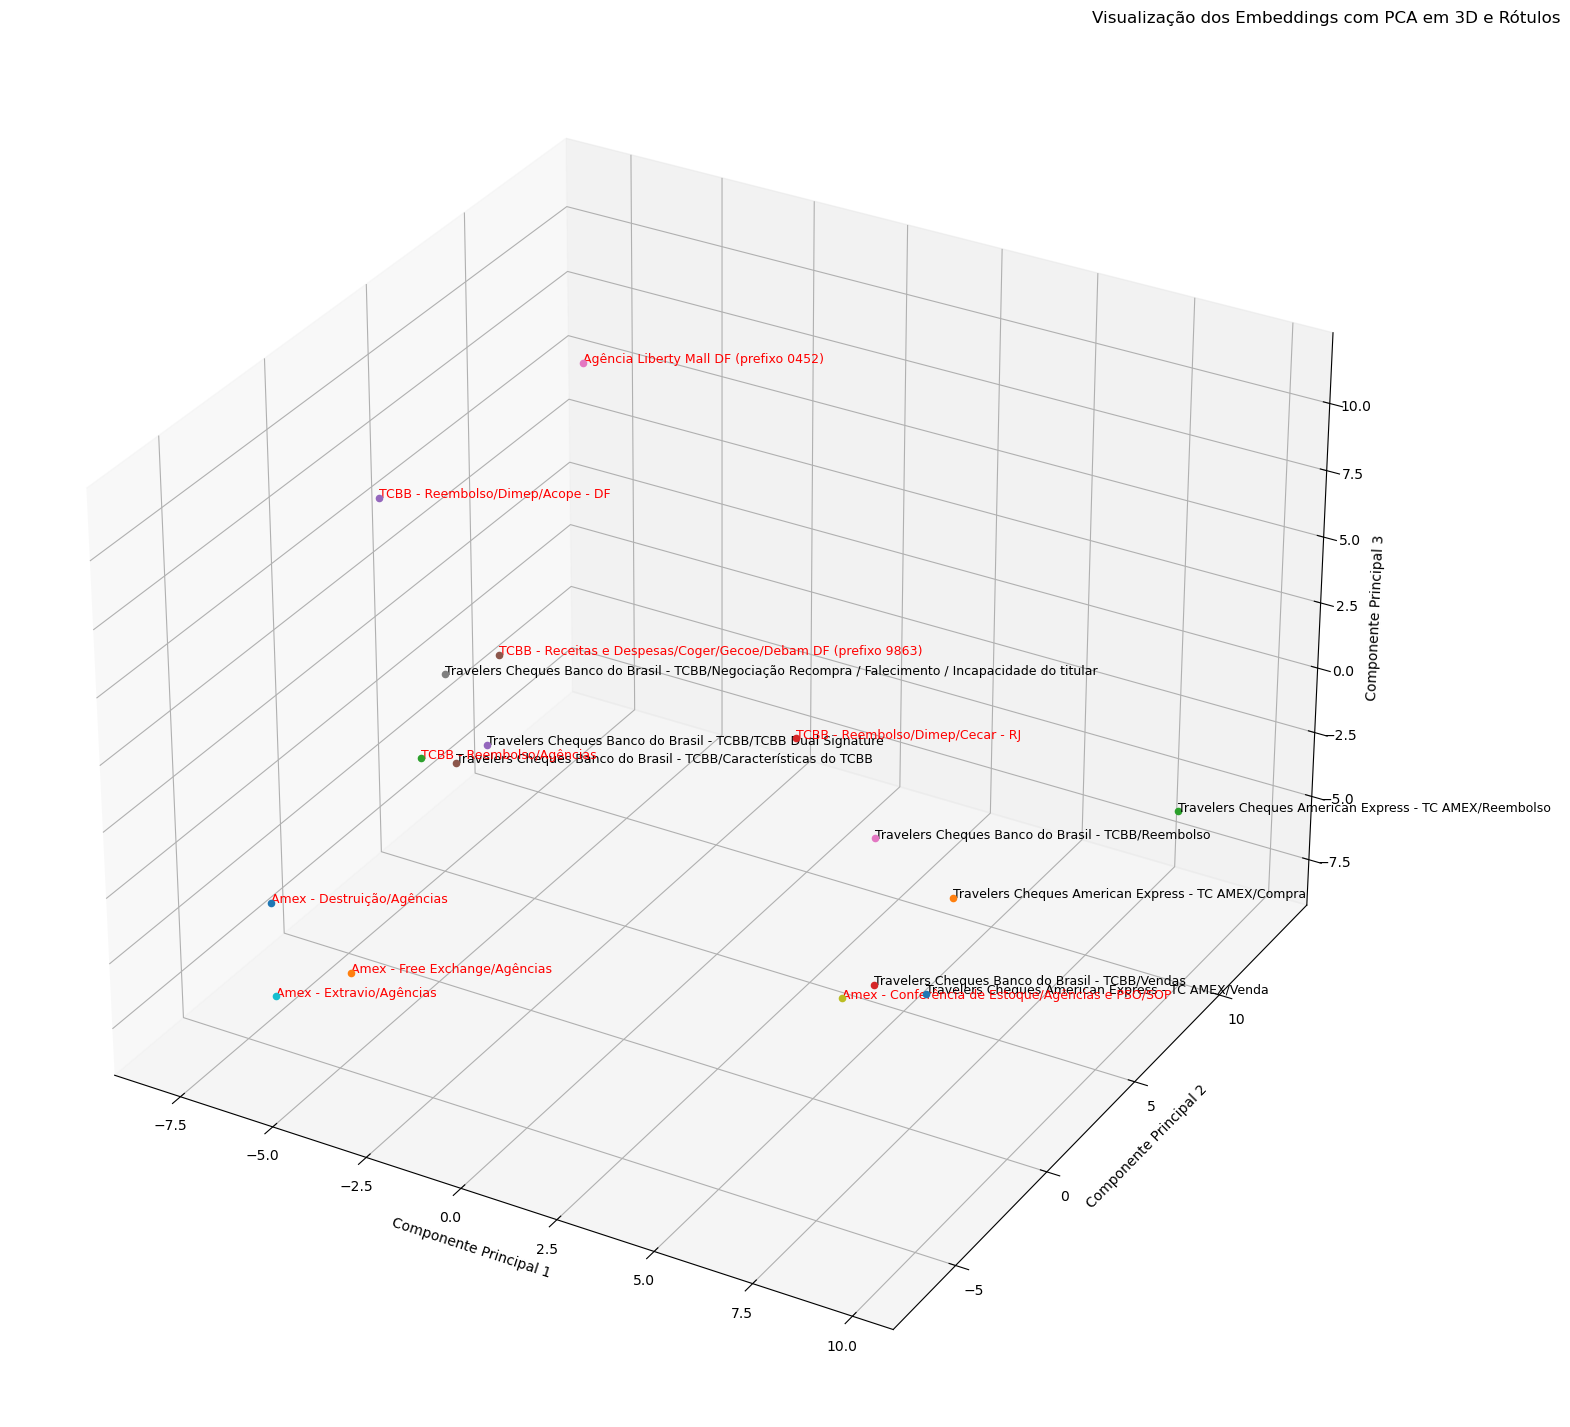

In [43]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

# Aplicar PCA para 3 componentes principais
pca = PCA(n_components=3)
embeddings_3d_pca = pca.fit_transform(flattened_embeddings)

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Iterar sobre os embeddings
for i in range(embeddings_3d_pca.shape[0]):
    ax.scatter(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i >= len(labels) - 9:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], color='red', fontsize=9)
    else:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], fontsize=9)

ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([0.95, 0.2])


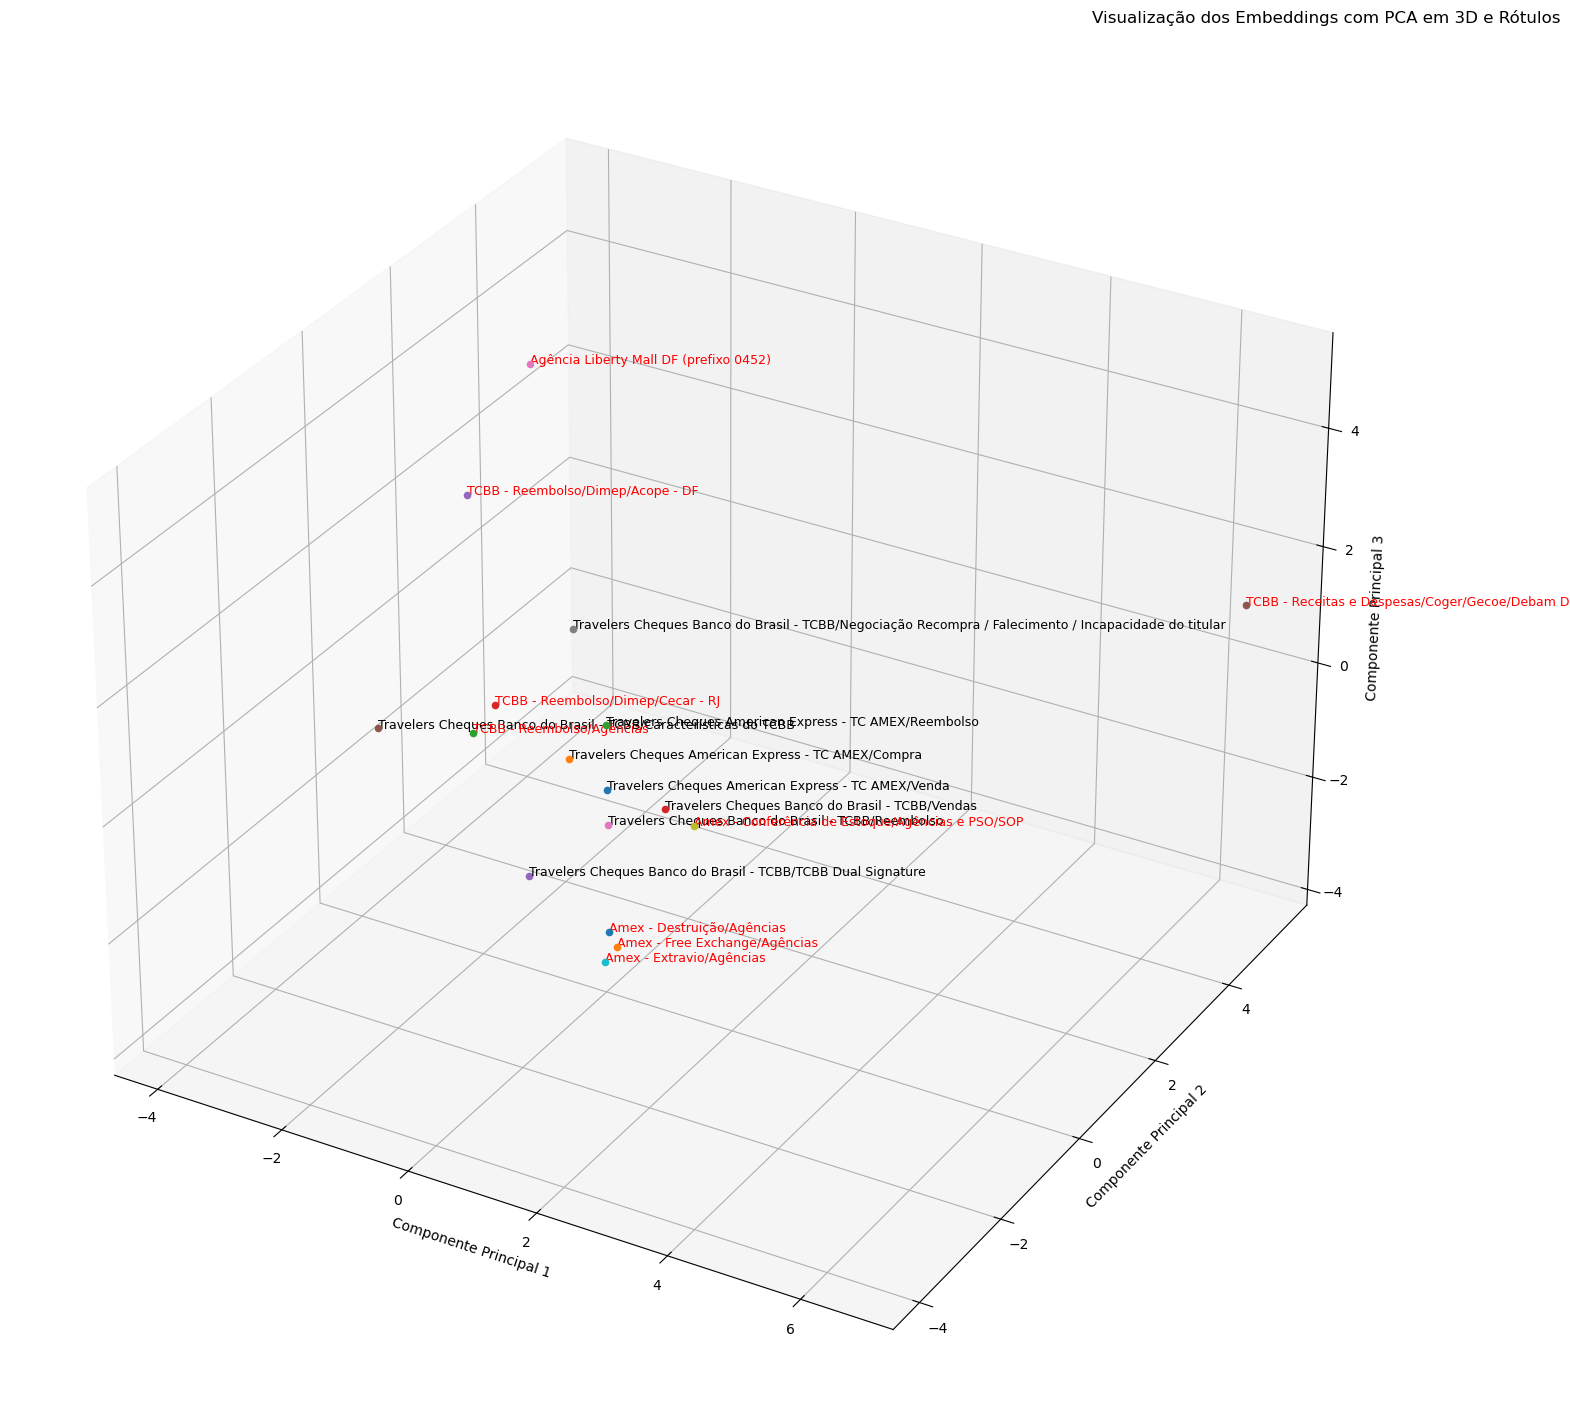

In [18]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

# Aplicar PCA para 3 componentes principais
pca = PCA(n_components=3)
embeddings_3d_pca = pca.fit_transform(flattened_embeddings)

labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Iterar sobre os embeddings
for i in range(embeddings_3d_pca.shape[0]):
    ax.scatter(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2])
    
    # Verificar se o rótulo está entre os últimos 9
    if i >= len(labels) - 9:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], color='red', fontsize=9)
    else:
        ax.text(embeddings_3d_pca[i, 0], embeddings_3d_pca[i, 1], embeddings_3d_pca[i, 2], labels[i], fontsize=9)

ax.set_title("Visualização dos Embeddings com PCA em 3D e Rótulos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.title.set_position([0.95, 0.2])


In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular a similaridade de cosseno entre os embeddings do PCA
similarity_matrix_pca = cosine_similarity(embeddings_3d_pca)

# Imprimir a matriz de similaridade
print("Matriz de Similaridade de Cosseno (PCA):")
print(similarity_matrix_pca)


Matriz de Similaridade de Cosseno (PCA):
[[ 9.9999994e-01  9.3652284e-01 -9.2869908e-01  9.7527635e-01
   9.5791501e-01  5.8639282e-01  7.7683741e-01  1.2663102e-01
   2.3837435e-01 -5.4415882e-01 -6.5616554e-01 -5.2324450e-01
  -5.8875781e-01 -2.7321777e-01 -6.2738812e-01 -2.7842231e-02
  -4.3734184e-01]
 [ 9.3652284e-01  1.0000000e+00 -8.0492538e-01  8.5528958e-01
   9.3893915e-01  8.2290655e-01  5.8746582e-01  3.8487372e-01
  -1.1500494e-01 -6.9073701e-01 -7.8124279e-01 -6.8385351e-01
  -3.3418667e-01  6.9430910e-02 -3.3460048e-01 -2.6464421e-01
  -1.7572725e-01]
 [-9.2869908e-01 -8.0492538e-01  1.0000001e+00 -8.8934571e-01
  -9.5148373e-01 -4.6960416e-01 -9.5178080e-01  2.2793224e-01
  -4.3559161e-01  1.9734028e-01  3.3310950e-01  1.7524947e-01
   4.9440724e-01  3.4366041e-01  8.1022233e-01  1.3544407e-01
   7.2338033e-01]
 [ 9.7527635e-01  8.5528958e-01 -8.8934571e-01  1.0000000e+00
   8.7627965e-01  4.1099545e-01  7.5260693e-01  9.1021217e-02
   3.7598512e-01 -5.4182690e-01 -6.46

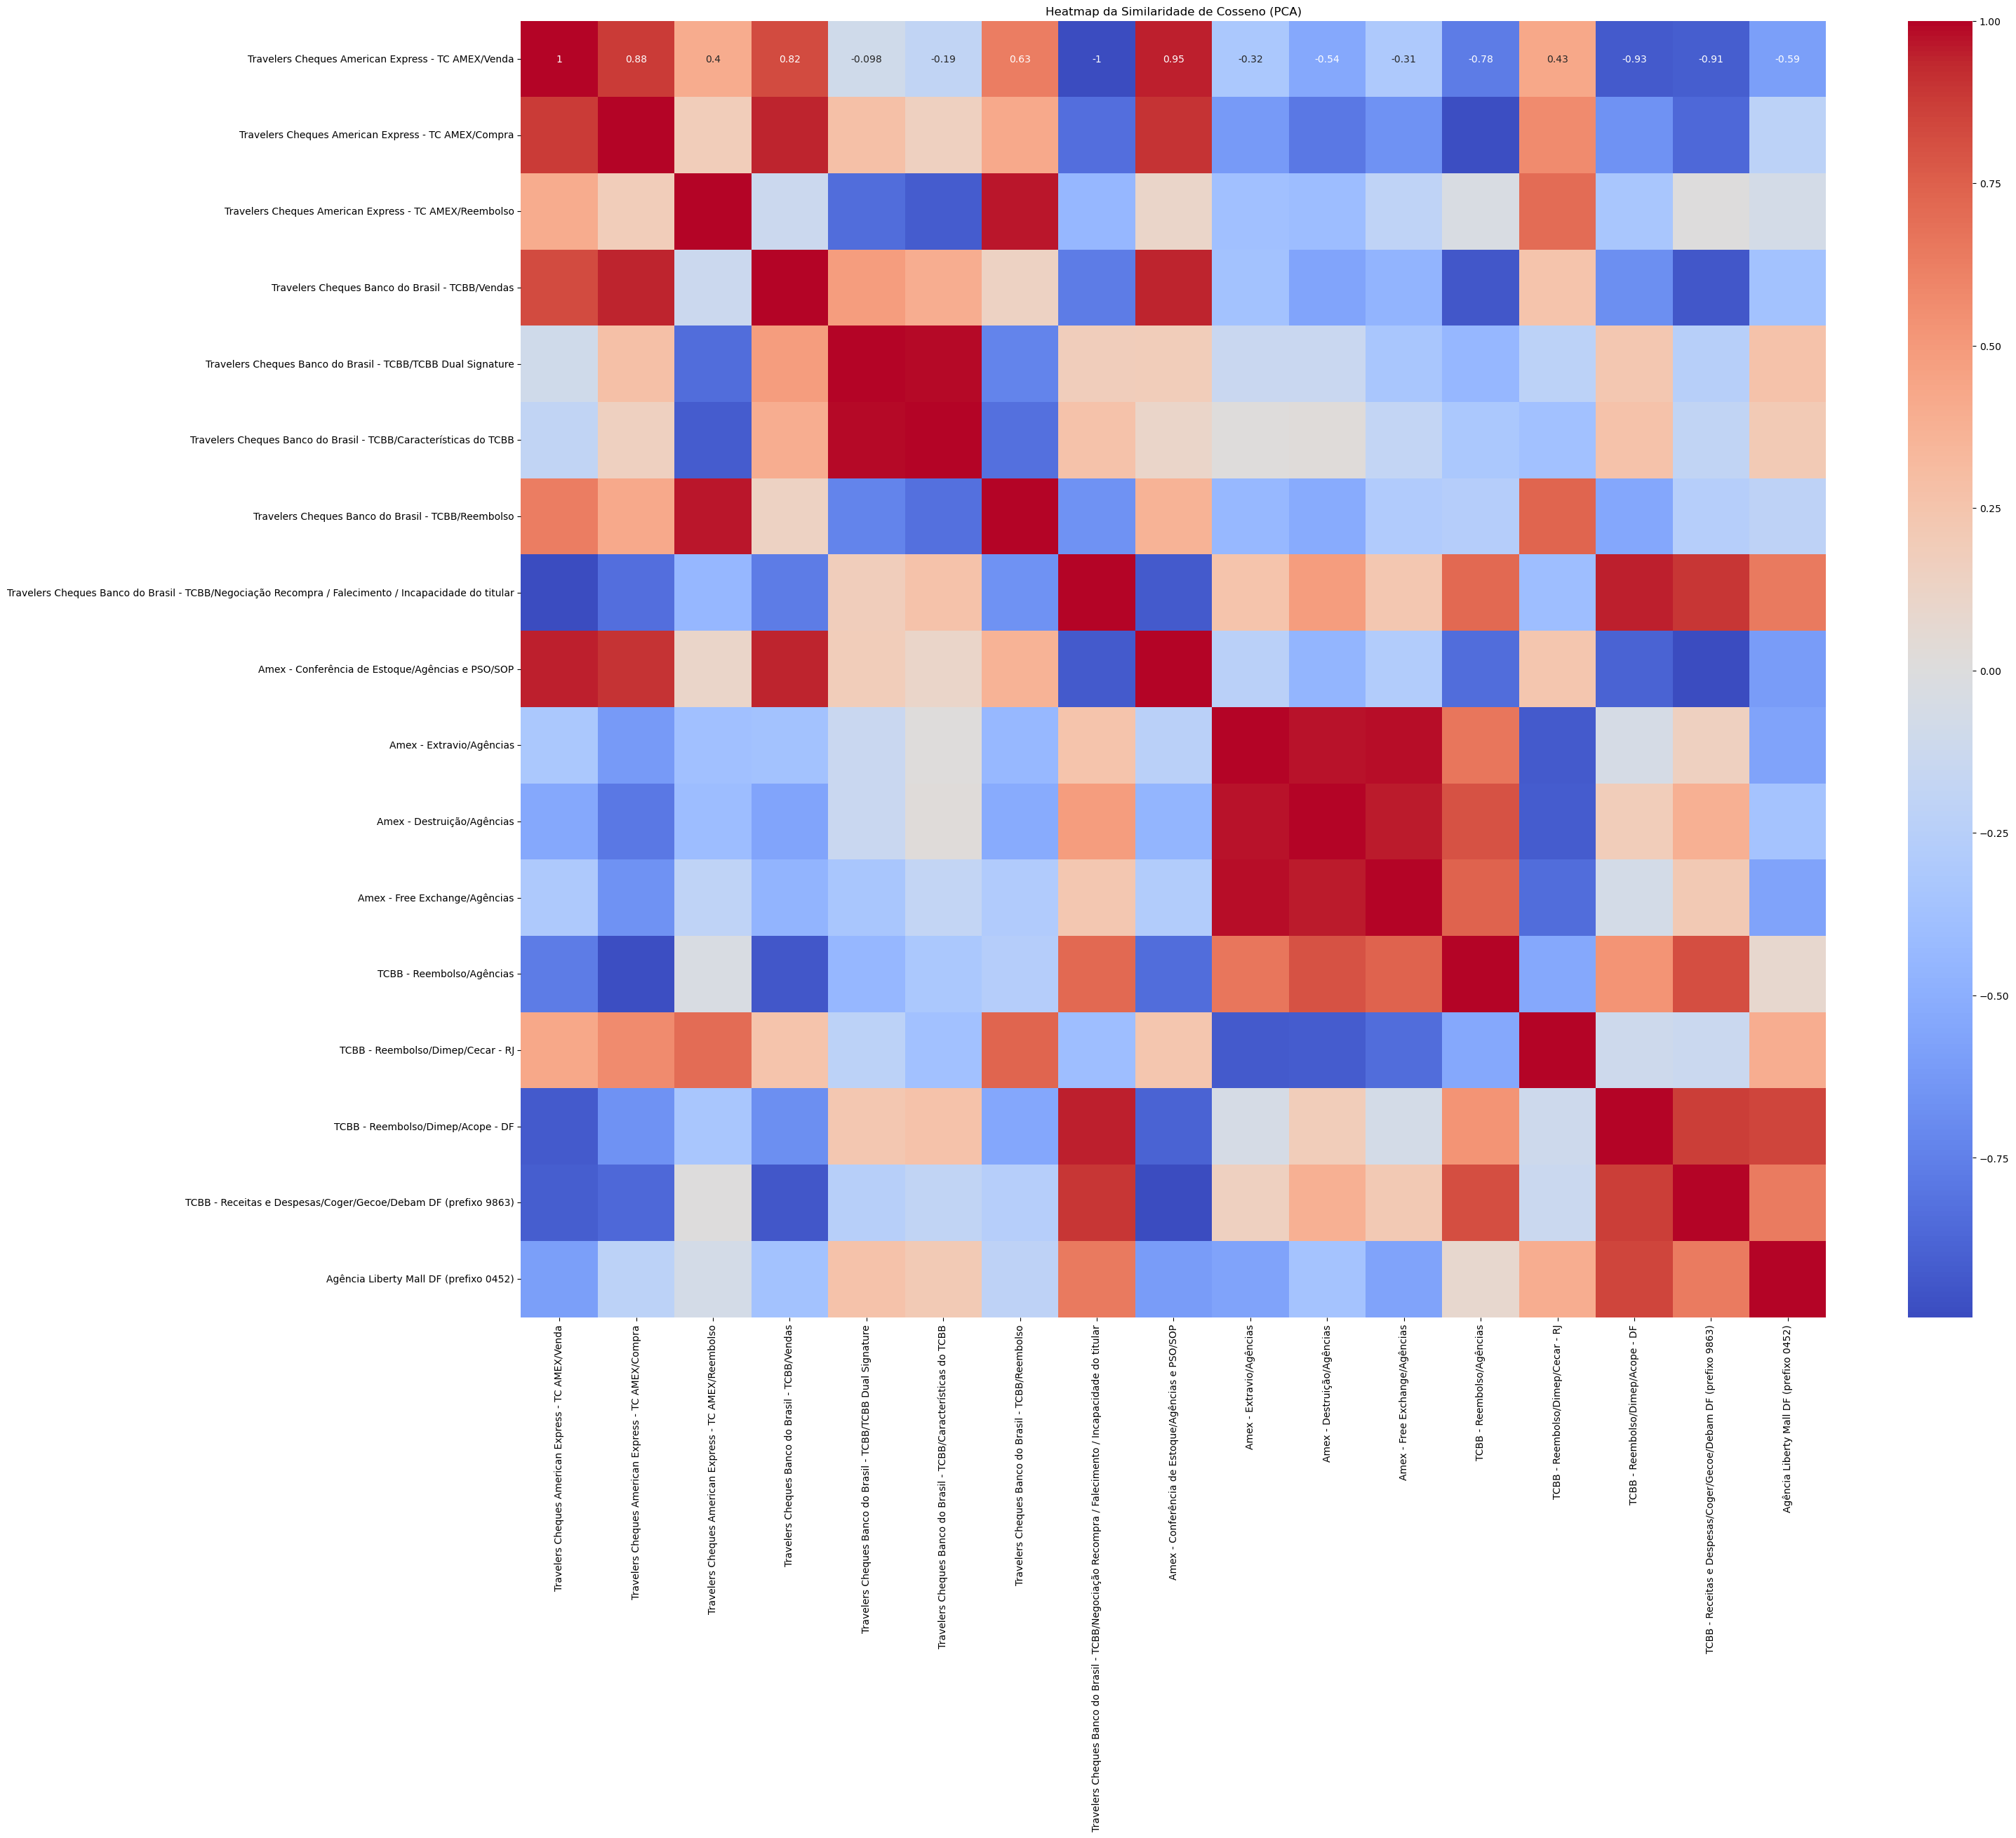

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Heatmap da matriz de similaridade de cosseno para os embeddings do PCA
plt.figure(figsize=(30, 24))
sns.heatmap(similarity_matrix_pca, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno (PCA)");


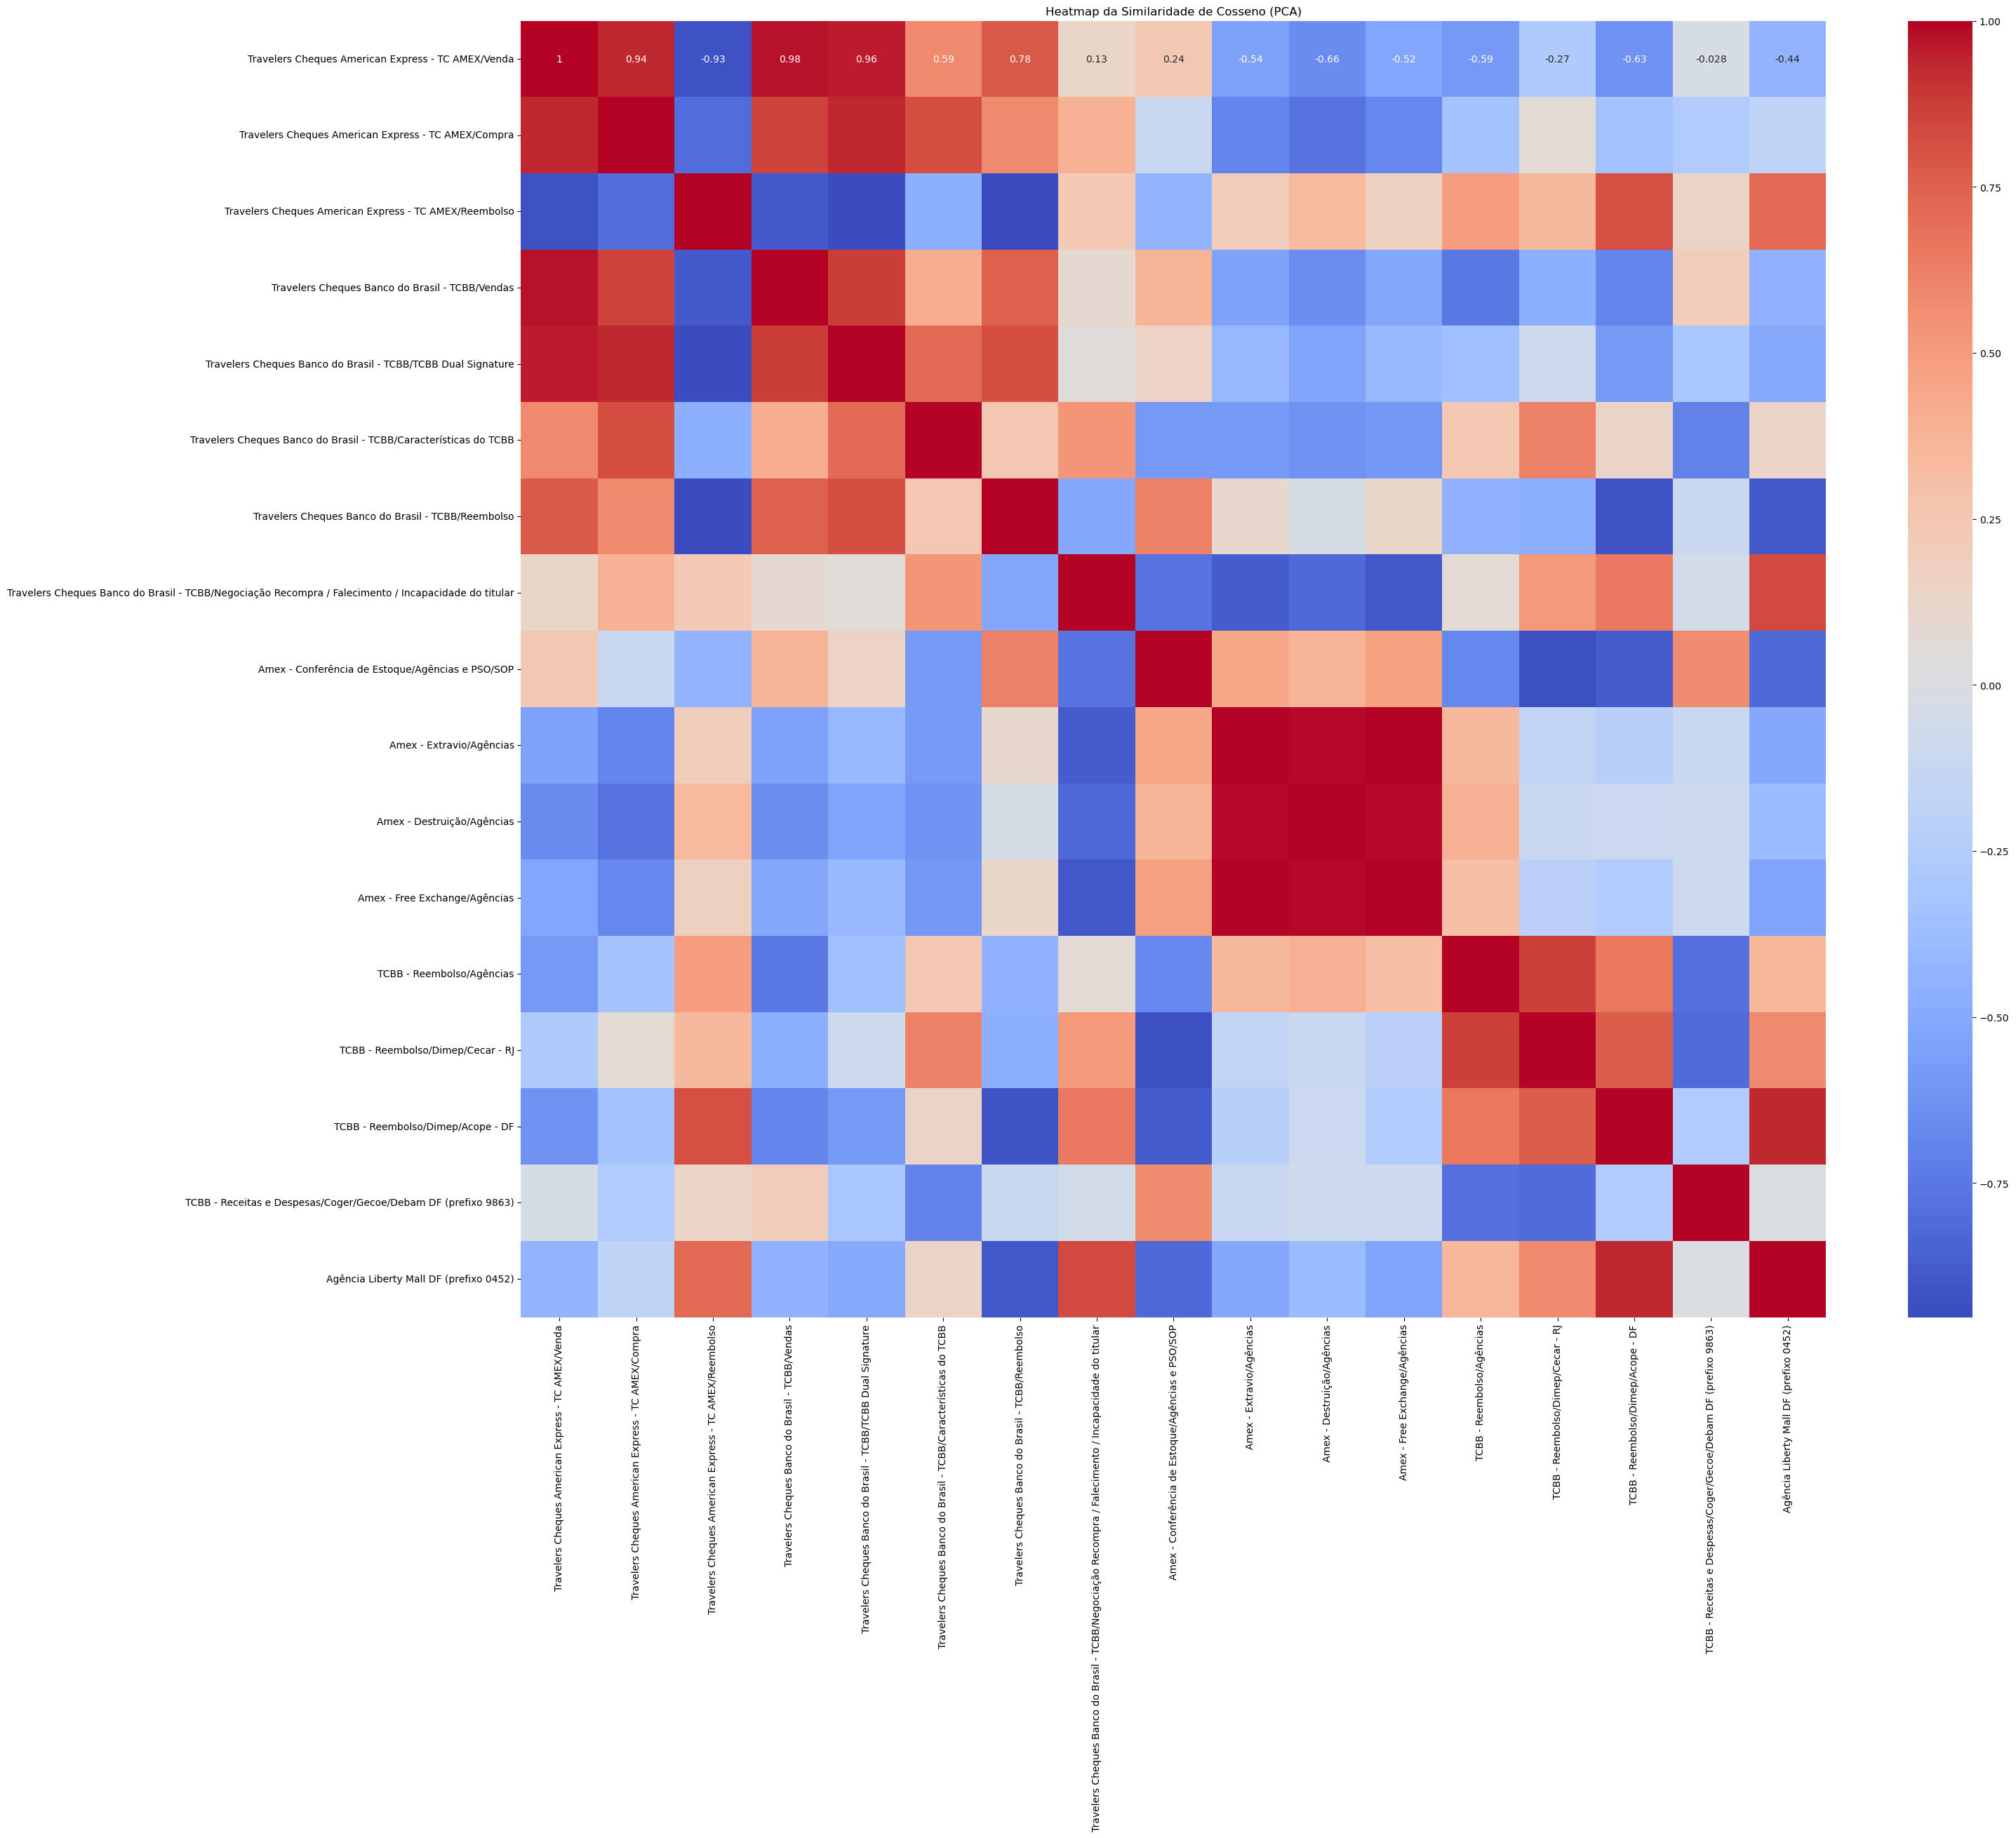

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Rótulos correspondentes a cada ponto
labels = [
    "Travelers Cheques American Express - TC AMEX/Venda",
    "Travelers Cheques American Express - TC AMEX/Compra",
    "Travelers Cheques American Express - TC AMEX/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Vendas",
    "Travelers Cheques Banco do Brasil - TCBB/TCBB Dual Signature",
    "Travelers Cheques Banco do Brasil - TCBB/Características do TCBB",
    "Travelers Cheques Banco do Brasil - TCBB/Reembolso",
    "Travelers Cheques Banco do Brasil - TCBB/Negociação Recompra / Falecimento / Incapacidade do titular",
    "Amex - Conferência de Estoque/Agências e PSO/SOP",
    "Amex - Extravio/Agências",
    "Amex - Destruição/Agências",
    "Amex - Free Exchange/Agências",
    "TCBB - Reembolso/Agências",
    "TCBB - Reembolso/Dimep/Cecar - RJ",
    "TCBB - Reembolso/Dimep/Acope - DF",
    "TCBB - Receitas e Despesas/Coger/Gecoe/Debam DF (prefixo 9863)",
    "Agência Liberty Mall DF (prefixo 0452)"
]

# Heatmap da matriz de similaridade de cosseno para os embeddings do PCA
plt.figure(figsize=(30, 24))
sns.heatmap(similarity_matrix_pca, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Heatmap da Similaridade de Cosseno (PCA)");
